https://datahack.analyticsvidhya.com/contest/janatahack-computer-vision-hackathon/

# Data Description

Total Images: 2352  
Train Images: 1646 (70%)  
Test Images: 706 (30%)  

`train.zip`: contains 2 csvs and 1 folder containing image data

`train.csv` – [‘image_names’, ‘emergency_or_not’] contains the image name and correct class for 1646 (70%) train images  

`images` – contains 2352 images for both train and test sets (

`test.csv`: [‘image_names’] contains just the image names for the 706 (30%) test images

`sample_submission.csv`: [‘image_names’,’emergency_or_not­’] contains the exact format for a valid submission (1 - For Emergency Vehicle, 0 - For Non Emergency Vehicle)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp -r '/content/drive/My Drive/EmergencyVehicleOrNot' /content/emergencydata
# !unzip '/content/emergencydata/train.zip' -d emergencydata

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd

In [4]:
img_dir = '/content/emergencydata/images'
train_set_csv = '/content/emergencydata/train.csv'
test_set_csv = '/content/emergencydata/test.csv'

In [5]:
dataset = pd.read_csv('/content/emergencydata/train.csv')
dataset

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0
...,...,...
1641,1638.jpg,0
1642,1095.jpg,0
1643,1130.jpg,0
1644,1294.jpg,0


# split data into train and validation set

In [6]:
from sklearn.model_selection import train_test_split



train_set, valid_set = train_test_split(dataset, test_size=0.2, random_state=42)

print(train_set.shape)
print(train_set.head(5))

print(valid_set.shape)
print(valid_set.head(5))

(1316, 2)
     image_names  emergency_or_not
819      796.jpg                 1
1022    1882.jpg                 0
1049     338.jpg                 1
692     1937.jpg                 0
544      871.jpg                 1
(330, 2)
     image_names  emergency_or_not
680      242.jpg                 1
1567    1495.jpg                 0
724     1451.jpg                 0
1142    1571.jpg                 0
1273    1119.jpg                 0


In [7]:
dataset_csv = pd.read_csv(train_set_csv)
dataset_csv.iloc[:, 0]

0       1503.jpg
1       1420.jpg
2       1764.jpg
3       1356.jpg
4       1117.jpg
          ...   
1641    1638.jpg
1642    1095.jpg
1643    1130.jpg
1644    1294.jpg
1645     860.jpg
Name: image_names, Length: 1646, dtype: object

In [8]:
np.asarray(dataset_csv.iloc[:, 0])

array(['1503.jpg', '1420.jpg', '1764.jpg', ..., '1130.jpg', '1294.jpg',
       '860.jpg'], dtype=object)

In [9]:
dataset_csv.iloc[:, 1]

0       0
1       0
2       0
3       0
4       0
       ..
1641    0
1642    0
1643    0
1644    0
1645    1
Name: emergency_or_not, Length: 1646, dtype: int64

In [10]:
np.asarray(dataset_csv.iloc[:, 1])

array([0, 0, 0, ..., 0, 0, 1])

In [11]:
from torch.utils.data.dataset import Dataset
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
import os


class VehicleDataset(Dataset):
  def __init__(self, input_df, img_folder_path, transform=None):
    '''
    Args:
      input_df (pandas Dataframe): Incoming dataframe with image information (image name, label etc)
      img_folder_path (string): folder with all the images
      transform (callable, optional): transform to be applied
    '''
    self.input_df = input_df
    self.img_folder_path = img_folder_path
    self.images = np.asarray(self.input_df.iloc[:, 0])
    self.labels = np.asarray(self.input_df.iloc[:, 1]) # asarray coverts to ndarray --> [4, 3, 4,...]
    self.transform = transform

  def __len__(self):
    return len(self.input_df.index)

  def __getitem__(self, idx):
    img_name = os.path.join(self.img_folder_path, self.images[idx])
    # Open image
    img = Image.open(img_name)
    label = self.labels[idx]
    if self.transform is not None:
      img = self.transform(img)

    return (img, label)


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [12]:
SEED = 1
BATCH_SIZE = 16

# Cuda?
cuda = torch.cuda.is_available()
print('CUDA available? ', cuda)

# For reproducibility
torch.manual_seed(seed=SEED)

if cuda:
  torch.cuda.manual_seed(seed=SEED)

# transforms the dataset into Tensors and does other things like augmentation, normalization etc.
transform_train = transforms.Compose([
                                transforms.RandomCrop(224, padding=4),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Get the dataset
# Loaders have dataset (grouped by batch_size) and configurations e.g. shuffle
trainloader = torch.utils.data.DataLoader(
    dataset = VehicleDataset(input_df=train_set, img_folder_path=img_dir, transform=transform_train),
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2
  )  # 1646 training images, so total batches = (1646 / 4)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    dataset = VehicleDataset(input_df=valid_set, img_folder_path=img_dir, transform=transform_test),
    batch_size=BATCH_SIZE // 2,
    shuffle=False,
    num_workers=2
  )

classes = (0, 1) # 1 = Emergency Vehicle, 0 = Not

CUDA available?  True


In [14]:
sample_train_data = iter(trainloader)
smpl_images, smpl_labels = sample_train_data.next()
print(smpl_labels.size(0))
print(smpl_labels)
print(smpl_images.shape)

16
tensor([1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0])
torch.Size([16, 3, 224, 224])


In [15]:
count = 0
for images, labels in iter(trainloader):  # images and labels grouped by batch_size
  print(images[count].shape)
  print(labels)
  count+=1
  if count == 1: break


torch.Size([3, 224, 224])
tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0])


In [16]:
# enumerate works slightly different, data has images and labels
count = 0
for i, data in enumerate(trainloader):  # images and labels grouped by batch_size
  # print(images)
  images, labels = data
  print(labels)
  count+=1
  if count == 1: break

tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])


Let us show some of the training images, for fun.



images shape:  torch.Size([16, 3, 224, 224])
    0             0             0             1
<generator object <genexpr> at 0x7f3eed93bfc0>


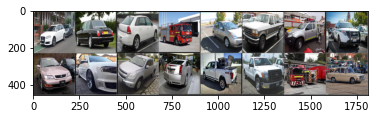

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show image
def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print('images shape: ', images.shape)  # torch.Size([4, 3, 32, 32])
# print('images: ', images)
# print('labels: ', labels)              # tensor([6, 3, 1, 0])

# show images
imshow(torchvision.utils.make_grid(images))
print('         '.join('%5s' % classes[labels[j]] for j in range(4)))
print(f'{classes[labels[j]] for j in range(4)}')

# 2. Define a Convolution Neural Network



In [18]:
import torch.nn as nn
import torch.nn.functional as F

dropout_value = 0.05

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    # Layer 1
    self.layer1 = nn.Sequential(
        # conv1
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(dropout_value),

        # conv2
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(64),

        # conv3
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(128),

        # conv4
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(256),
    )
    self.pool1 = nn.MaxPool2d(2, 2)     
    
    # Layer 2
    self.layer2 = nn.Sequential(
        # conv1
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(512),
        nn.Dropout(dropout_value),

        # conv2
        nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        # conv3
        nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(128),

        # conv4
        nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(64),
    )
    self.pool2 = nn.MaxPool2d(2, 2)  

    # Layer 3
    self.layer3 = nn.Sequential(
        # conv1
        nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(dropout_value),

        # conv2
        nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16),

        # conv3
        nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(8),

        # conv4
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16),   
    )
    self.pool3 = nn.MaxPool2d(2, 2)
    
    # Layer 4
    self.layer4 = nn.Sequential(
        # conv1
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(dropout_value),

        # conv2
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(64),

        # conv3
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(64),

        # conv4
        nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(32),
      )
    self.pool4 = nn.MaxPool2d(2, 2)

    # Layer 5
    self.layer5 = nn.Sequential(
        # conv1
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Dropout(dropout_value),

        # conv2
        nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(32),

        # conv3
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(64),

        # conv4
        nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(32),
      )

    # Add GAP 
    self.gap   = nn.AdaptiveAvgPool2d(output_size=1)
    # Final layer - works as FC layer
    self.layer6 = nn.Sequential(
        # conv9
        nn.Conv2d(in_channels=32, out_channels=2, kernel_size=1)
    )
   
  def forward(self, x):
    x = self.layer1(x)
    x = self.pool1(x)

    x = self.layer2(x)
    x = self.pool2(x)

    x = self.layer3(x)
    x = self.pool3(x)

    x = self.layer4(x)
    x = self.pool4(x)

    x = self.layer5(x)
    x = self.gap(x)

    x = self.layer6(x)

    x = x.view(-1, 2)
    x = F.log_softmax(x, dim=-1)

    return x

# Model Summary

In [19]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
net = Net().to(device)
summary(net, input_size=(3, 225, 225))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 225, 225]             864
              ReLU-2         [-1, 32, 225, 225]               0
       BatchNorm2d-3         [-1, 32, 225, 225]              64
           Dropout-4         [-1, 32, 225, 225]               0
            Conv2d-5         [-1, 64, 225, 225]          18,432
              ReLU-6         [-1, 64, 225, 225]               0
       BatchNorm2d-7         [-1, 64, 225, 225]             128
            Conv2d-8        [-1, 128, 223, 223]          73,728
              ReLU-9        [-1, 128, 223, 223]               0
      BatchNorm2d-10        [-1, 128, 223, 223]             256
           Conv2d-11        [-1, 256, 221, 221]         294,912
             ReLU-12        [-1, 256, 221, 221]               0
      BatchNorm2d-13        [-1, 256, 221, 221]             512
        MaxPool2d-14        [-1, 256, 1

# 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [20]:
from tqdm import tqdm
from pathlib import Path

train_acc = []
train_loss = []

def train(net, device, trainloader, optimizer, epoch):
  net.train()
  pbar = tqdm(trainloader) # returns iterable of trainloader
  running_loss = 0.0
  correct = 0
  processed = 0

  for batch_idx, (inputs, labels) in enumerate(pbar):
    # get the inputs
    inputs, labels = inputs.to(device), labels.to(device)  # convert data to tensors

    # zero the paramter gradients
    optimizer.zero_grad()

    # forward
    outputs = net(inputs)

    loss = criterion(outputs, labels)
    train_loss.append(loss)
    # backward
    loss.backward()

    # optimize
    optimizer.step()

    # print statistics
    running_loss += loss.item()

    _, predictions = torch.max(outputs.data, 1)
    correct = correct + (predictions == labels).sum().item()
    processed = processed + len(inputs)

    pbar.set_description(desc=f'Epoch={epoch} Loss={loss.item()} Batch_id={batch_idx} Train_Accuracy={100 * correct / processed:0.2f}')

    train_acc.append(100 * correct / processed)

  # save the model after 50 epoch
  if(epoch % 20 == 0):
    print('\n==> Saving model ...')
    state = {
        'model': net.state_dict(),
        'epoch': epoch
    }
    model_path = Path('model_{epoch}.pt'.format(epoch=epoch))
    torch.save(state, model_path)

In [21]:
test_acc = []
test_loss = []

def test(net, device, testloader):
  net.eval()
  correct = 0
  total = 0
  loss = 0
  with torch.no_grad():
    for data in testloader:
      images, labels = data
      images, labels = images.cuda(), labels.cuda()
      outputs = net(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      # print((predicted == labels).sum().item())     # sum() => sum of correctly predicted images in a batch (here batch_size=4)
      # sum().item() : [4] to 4
      correct += (predicted == labels).sum().item()
  loss = loss / len(testloader.dataset)
  test_loss.append(loss)

  print(f'Accuracy of the network on the 680 validation images: {correct / total * 100}')
  test_acc.append(100. * correct / len(testloader.dataset))

# 3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [22]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

EPOCHS = 50

for epoch in range(1, EPOCHS):
  train(net, device, trainloader, optimizer, epoch)
  test(net, device, testloader)

Epoch=1 Loss=0.6890689730644226 Batch_id=82 Train_Accuracy=65.43: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 66.66666666666666


Epoch=2 Loss=0.8211613893508911 Batch_id=82 Train_Accuracy=75.23: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 70.0


Epoch=3 Loss=1.1522427797317505 Batch_id=82 Train_Accuracy=82.14: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 79.6969696969697


Epoch=4 Loss=0.31329476833343506 Batch_id=82 Train_Accuracy=83.05: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 84.84848484848484


Epoch=5 Loss=0.10017795115709305 Batch_id=82 Train_Accuracy=85.56: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 81.21212121212122


Epoch=6 Loss=0.21627922356128693 Batch_id=82 Train_Accuracy=87.01: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 85.75757575757575


Epoch=7 Loss=0.7189127206802368 Batch_id=82 Train_Accuracy=88.37: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 87.27272727272727


Epoch=8 Loss=0.07073988020420074 Batch_id=82 Train_Accuracy=89.97: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 85.45454545454545


Epoch=9 Loss=0.17123287916183472 Batch_id=82 Train_Accuracy=89.74: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 87.57575757575758


Epoch=10 Loss=0.5257315039634705 Batch_id=82 Train_Accuracy=91.19: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 87.87878787878788


Epoch=11 Loss=0.2559942901134491 Batch_id=82 Train_Accuracy=89.67: 100%|██████████| 83/83 [00:31<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 84.24242424242424


Epoch=12 Loss=0.07724806666374207 Batch_id=82 Train_Accuracy=91.49: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 86.06060606060606


Epoch=13 Loss=0.5574565529823303 Batch_id=82 Train_Accuracy=91.26: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 86.36363636363636


Epoch=14 Loss=0.04249848052859306 Batch_id=82 Train_Accuracy=90.81: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 84.84848484848484


Epoch=15 Loss=0.6025356650352478 Batch_id=82 Train_Accuracy=93.01: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 77.27272727272727


Epoch=16 Loss=1.623205542564392 Batch_id=82 Train_Accuracy=90.58: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 85.45454545454545


Epoch=17 Loss=0.06494547426700592 Batch_id=82 Train_Accuracy=92.48: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 86.36363636363636


Epoch=18 Loss=0.10619541257619858 Batch_id=82 Train_Accuracy=94.30: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 87.57575757575758


Epoch=19 Loss=0.043905653059482574 Batch_id=82 Train_Accuracy=94.45: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 87.87878787878788


Epoch=20 Loss=0.28230851888656616 Batch_id=82 Train_Accuracy=94.68: 100%|██████████| 83/83 [00:31<00:00,  2.68it/s]



==> Saving model ...


  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 84.24242424242424


Epoch=21 Loss=0.031221069395542145 Batch_id=82 Train_Accuracy=95.29: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 90.0


Epoch=22 Loss=0.7157840132713318 Batch_id=82 Train_Accuracy=95.14: 100%|██████████| 83/83 [00:31<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 86.66666666666667


Epoch=23 Loss=0.027324853464961052 Batch_id=82 Train_Accuracy=93.39: 100%|██████████| 83/83 [00:31<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 87.87878787878788


Epoch=24 Loss=0.051031444221735 Batch_id=82 Train_Accuracy=94.15: 100%|██████████| 83/83 [00:31<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 89.6969696969697


Epoch=25 Loss=0.5744866132736206 Batch_id=82 Train_Accuracy=94.68: 100%|██████████| 83/83 [00:31<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 86.66666666666667


Epoch=26 Loss=0.6881575584411621 Batch_id=82 Train_Accuracy=94.53: 100%|██████████| 83/83 [00:31<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 88.7878787878788


Epoch=27 Loss=0.13052132725715637 Batch_id=82 Train_Accuracy=94.00: 100%|██████████| 83/83 [00:31<00:00,  2.67it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 86.96969696969697


Epoch=28 Loss=0.7323169708251953 Batch_id=82 Train_Accuracy=95.44: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 86.06060606060606


Epoch=29 Loss=0.3499804735183716 Batch_id=82 Train_Accuracy=94.22: 100%|██████████| 83/83 [00:31<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 88.18181818181819


Epoch=30 Loss=0.014392919838428497 Batch_id=82 Train_Accuracy=95.52: 100%|██████████| 83/83 [00:31<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 89.39393939393939


Epoch=31 Loss=0.18959304690361023 Batch_id=82 Train_Accuracy=95.82: 100%|██████████| 83/83 [00:31<00:00,  2.67it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 88.48484848484848


Epoch=32 Loss=0.01055868435651064 Batch_id=82 Train_Accuracy=95.90: 100%|██████████| 83/83 [00:31<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 88.48484848484848


Epoch=33 Loss=0.016054466366767883 Batch_id=82 Train_Accuracy=96.58: 100%|██████████| 83/83 [00:31<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 89.0909090909091


Epoch=34 Loss=1.6273075342178345 Batch_id=82 Train_Accuracy=97.34: 100%|██████████| 83/83 [00:31<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 89.0909090909091


Epoch=35 Loss=1.0477674007415771 Batch_id=82 Train_Accuracy=94.68: 100%|██████████| 83/83 [00:31<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 86.66666666666667


Epoch=36 Loss=0.0123970415443182 Batch_id=82 Train_Accuracy=95.90: 100%|██████████| 83/83 [00:31<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 90.9090909090909


Epoch=37 Loss=0.05093447118997574 Batch_id=82 Train_Accuracy=97.87: 100%|██████████| 83/83 [00:31<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 89.39393939393939


Epoch=38 Loss=0.008778933435678482 Batch_id=82 Train_Accuracy=96.35: 100%|██████████| 83/83 [00:31<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 89.39393939393939


Epoch=39 Loss=0.6775776743888855 Batch_id=82 Train_Accuracy=96.96: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 90.6060606060606


Epoch=40 Loss=0.38271164894104004 Batch_id=82 Train_Accuracy=94.68: 100%|██████████| 83/83 [00:31<00:00,  2.67it/s]


==> Saving model ...



  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 86.66666666666667


Epoch=41 Loss=0.13354171812534332 Batch_id=82 Train_Accuracy=95.52: 100%|██████████| 83/83 [00:31<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 89.0909090909091


Epoch=42 Loss=1.955129861831665 Batch_id=82 Train_Accuracy=95.82: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 90.0


Epoch=43 Loss=0.16526378691196442 Batch_id=82 Train_Accuracy=97.87: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 89.39393939393939


Epoch=44 Loss=0.26201045513153076 Batch_id=82 Train_Accuracy=97.87: 100%|██████████| 83/83 [00:31<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 87.57575757575758


Epoch=45 Loss=0.20259979367256165 Batch_id=82 Train_Accuracy=97.64: 100%|██████████| 83/83 [00:30<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 88.7878787878788


Epoch=46 Loss=1.7385815382003784 Batch_id=82 Train_Accuracy=98.78: 100%|██████████| 83/83 [00:31<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 90.6060606060606


Epoch=47 Loss=0.01838766224682331 Batch_id=82 Train_Accuracy=97.49: 100%|██████████| 83/83 [00:31<00:00,  2.68it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 90.30303030303031


Epoch=48 Loss=0.42586997151374817 Batch_id=82 Train_Accuracy=98.02: 100%|██████████| 83/83 [00:31<00:00,  2.67it/s]
  0%|          | 0/83 [00:00<?, ?it/s]

Accuracy of the network on the 680 validation images: 89.6969696969697


Epoch=49 Loss=0.0028991091530770063 Batch_id=82 Train_Accuracy=97.95: 100%|██████████| 83/83 [00:31<00:00,  2.67it/s]


Accuracy of the network on the 680 validation images: 89.0909090909091


# 5. Test the network on the test data


We have trained the network for 50 passes over the training dataset.
Let's check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Let us display an image from the test set to get familiar.



GroundTruth:     1     0     0     0     0     0     0     1


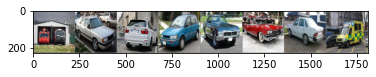

In [30]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images  
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

Okay, now let us see what the neural network thinks these examples above are:



In [24]:
images, labels = images.cuda(), labels.cuda()

outputs = net(images)

In [28]:
outputs

tensor([[-4.9591e-05, -9.9064e+00],
        [-7.1764e-04, -7.2400e+00]], device='cuda:0')

The outputs are energies for the 2 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [25]:
_, predicted = torch.max(outputs, 1) # picks the max value

print(predicted)
print(classes)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(8)))

tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
(0, 1)
Predicted:      1     0     0     0     0     0     0     1


That looks waaay better than chance, which is 50% accuracy (randomly picking
a class out of 2 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [26]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
class_correct

[0.0, 0.0]

In [29]:
with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.cuda(), labels.cuda()
    # print(images.shape)   # torch.Size([8, 3, 224, 224])
    # print(labels)         # tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
    # print(labels.shape)   # torch.Size([8])
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    # print(c)             # tensor([False,  True,  True,  True,  True,  True,  True,  True], device='cuda:0')
    for i in range(8):
      try:
        label = labels[i]
        class_correct[label] += c[i].item()     # c[i].item() returns 1 if True
        class_total[label] += 1
      except IndexError:
        print('It is the last batch with less images :) ')
        continue

for i in range(2):
  print(f'Accuracy of {classes[i]} : {100 * class_correct[i] / class_total[i]}')

It is the last batch with less images :) 
It is the last batch with less images :) 
It is the last batch with less images :) 
It is the last batch with less images :) 
It is the last batch with less images :) 
It is the last batch with less images :) 
Accuracy of 0 : 94.94949494949495
Accuracy of 1 : 80.3030303030303
